In [11]:
import pandas as pd
import regex as re
import msoffcrypto
import openpyxl
from io import BytesIO
#pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt


## Loading the data

In [12]:
#Load all the data into dataframes from our documents
censo = pd.read_csv(r"Comercial_Censo.csv",sep=";", encoding='latin1')
meteo=pd.read_csv(r"Comercial_Meteorología.csv")
com_test=pd.read_csv(r"Comercial_Test.csv",sep=";", encoding='latin1')
ventas=pd.read_csv(r"Comercial_Ventas.csv",sep=";", encoding='latin1')

#The excel document is encrypted, we need to decrypt it
file_path = r"Comercial_ParqueVehiculos1.xlsx"
password = "IndesIA2022!"

with open(file_path, 'rb') as file:
    encrypted_file = msoffcrypto.OfficeFile(file)
    encrypted_file.load_key(password=password)
    
    decrypted_file = BytesIO()
    encrypted_file.decrypt(decrypted_file)
    decrypted_file.seek(0)

    #We load the data from the excel file differenciating the years
    parque2016 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=0, header=2)
    parque2017 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=1, header=2)
    parque2018 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=2, header=2)


## Cleaning Censo Dataset

In [13]:
def clean_name(text):
    return re.sub(r'^\d+\s*', '', text).strip()
censo['Municipio'] = censo['Municipio'].apply(clean_name)

dfs = []

#Lets transform the dataframe to handle easier the data
for year in censo.columns[1:]:
    temp_df = censo[['Municipio', year]].copy()
    temp_df.columns = ['Municipio', 'Total_Poblacion']
    temp_df['Año'] = year
    dfs.append(temp_df)

df_concatenated = pd.concat(dfs, ignore_index=True)
censo=df_concatenated

## Cleaning the Meteo Dataset

In [14]:
#Dropping the unnamed columns
meteo=meteo.drop(columns=["Unnamed: 0"])

#Fixing the name of the populations
meteo=meteo.replace("A CORUA","Coruña, A")

#Dropping useless columns
meteo.drop(columns=["provincia","indicativo","nombre"],inplace=True)

#Transforming the date to datetime
meteo["fecha"]=pd.to_datetime(meteo["fecha"])

#Creating new date columns
meteo['Year'] = pd.DatetimeIndex(meteo['fecha']).year
meteo['Month'] = pd.DatetimeIndex(meteo['fecha']).month 
meteo['Day'] = pd.DatetimeIndex(meteo['fecha']).day 
meteo['Weekday'] = pd.DatetimeIndex(meteo['fecha']).weekday

#Checking null values
meteo.isna().sum()
meteo.loc[meteo.isna().any(axis=1)]
meteo=meteo.dropna()

#Setting the date column as the index
#meteo.set_index("fecha",inplace=True)

## Cleaning Test Dataset

In [15]:
# Dropping the Unnamed column
com_test=com_test.drop(columns=["Unnamed: 0"])

# Converting the Dia column to datetime
com_test["Dia"] = pd.to_datetime(com_test["Dia"])

#Creating new date columns
com_test['Year'] = pd.DatetimeIndex(com_test['Dia']).year
com_test['Month'] = pd.DatetimeIndex(com_test['Dia']).month 
com_test['Day'] = pd.DatetimeIndex(com_test['Dia']).day 
com_test['Weekday'] = pd.DatetimeIndex(com_test['Dia']).weekday

#Importing a new dataset with the holidays in Spain in 2019 from the Spain Goverment website
file_path = 'Festivos_España_2019.csv'
fiestas2019 = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and transforming the data
fiestas2019.head()
fiestas2019['Año'] = 2019
fiestas2019.drop(columns="Descripcion",inplace=True)

# Creating a mapping dictionary for the months to a better performance
month_mapping = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Apply the mapping to the "Mes" column
fiestas2019['Mes'] = fiestas2019['Mes'].map(month_mapping)

# Create a new 'Fecha' column by combining 'Mes', 'Dia', and 'Año'
fiestas2019['Fecha'] = pd.to_datetime(fiestas2019['Dia'].astype(str) + '-' + fiestas2019['Mes'].astype(str) + '-' + fiestas2019['Año'].astype(str), format='%d-%m-%Y')

# Drop the redundant columns
fiestas2019.drop(columns=['Mes', 'Dia', 'Año'], inplace=True)

#Adding a new column on the DataFrame
com_test['Fiesta'] = com_test['Dia'].isin(fiestas2019['Fecha']).astype(int)

#setting the index to the date
#com_test.set_index("Dia",inplace=True)

## Cleaning Ventas Dataset

In [16]:
#Dummifying the column Fiesta
ventas["Fiesta"]= ventas["Fiesta"].apply(lambda x: 1 if pd.notna(x) else 0)

#Creating date columns
ventas['Year'] = pd.DatetimeIndex(ventas['Dia']).year
ventas['Month'] = pd.DatetimeIndex(ventas['Dia']).month 
ventas['Day'] = pd.DatetimeIndex(ventas['Dia']).day 
ventas['Weekday'] = pd.DatetimeIndex(ventas['Dia']).weekday

#Lets check the missing values in the ventas dataset
ventas.info()
ventas.loc[ventas.isna().any(axis=1)]

#We take a look on the column PVP to analyze the possible cause od the missing values. Seeing that is a small amount of data we can drop it
pvpnan=ventas.loc[ventas["PVP"].isna()==True]

ventas=ventas.dropna()

#Setting the index to the date
ventas["Dia"] = pd.to_datetime(ventas["Dia"], format='%d/%m/%Y')
#ventas.set_index("Dia",inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Dia       26304 non-null  object
 1   Producto  26304 non-null  object
 2   Latitud   26303 non-null  object
 3   Longitud  26303 non-null  object
 4   PVP       25080 non-null  object
 5   VentasN   26288 non-null  object
 6   Nombre    26304 non-null  object
 7   Day       26304 non-null  int32 
 8   Month     26304 non-null  int32 
 9   Year      26304 non-null  int32 
 10  Weekday   26304 non-null  int32 
 11  Fiesta    26304 non-null  int64 
dtypes: int32(4), int64(1), object(7)
memory usage: 2.0+ MB


## Cleaning Parque Dataset

In [17]:
parque2016.columns=parque2016.columns.str.replace("\n"," ")
parque2017.columns=parque2017.columns.str.replace("\n"," ")
parque2018.columns=parque2018.columns.str.replace("\n"," ")

#Lets clean thhe parques dataset
parque2016=parque2016.drop(columns=["PROVINCIAS"])
parque2017=parque2017.drop(columns=["PROVINCIAS"])
parque2018=parque2018.drop(columns=["PROVINCIAS"])

#We rename the columns to avoid confusion when merging the dataframes 
parque2016=parque2016.add_suffix("_2016")
parque2017=parque2017.add_suffix("_2017")
parque2018=parque2018.add_suffix("_2018")

#This dataset has the Camiones and furgonetas merged, while the others it has them separated. We will merge them in the other datasets due we dont have the data about the individual types of vehicles
parque2016.columns

parque2017["CAMIONES y FURGONETAS_2017"]=parque2017["CAMIONES_2017"]+parque2017["FURGONETAS_2017"]
parque2017=parque2017.drop(columns=["CAMIONES_2017","FURGONETAS_2017"])

parque2018["CAMIONES y FURGONETAS_2018"]=parque2018["CAMIONES_2018"]+parque2018["FURGONETAS_2018"]
parque2018=parque2018.drop(columns=["CAMIONES_2018","FURGONETAS_2018"])

#Rename the columns to merge the datasets
parque2016 = parque2016.rename(columns={"MUNICIPIOS_2016": "MUNICIPIOS"})
parque2017 = parque2017.rename(columns={"MUNICIPIOS_2017": "MUNICIPIOS"})
parque2018 = parque2018.rename(columns={"MUNICIPIOS_2018": "MUNICIPIOS"})

#Lets create a single dataset with the data from the 3 years
parque_m=pd.merge(parque2016,parque2017,how="inner",on="MUNICIPIOS")
parque=pd.merge(parque_m,parque2018,how="inner",on="MUNICIPIOS")

parque.columns=parque.columns.str.capitalize()

years = ['2016', '2017', '2018']

long_format = []
for index, row in parque.iterrows():
    for year in years:
        long_format.append({
            'Municipios': row['Municipios'],
            'year': year,
            'Camiones y furgonetas': row[f'Camiones y furgonetas_{year}'],
            'Autobuses': row[f'Autobuses_{year}'],
            'Turismos': row[f'Turismos_{year}'],
            'Motocicletas': row[f'Motocicletas_{year}'],
            'Tractores industriales': row[f'Tractores industriales_{year}'],
            'Remolques y semirremolques': row[f'Remolques y semirremolques_{year}'],
            'Otros vehículos': row[f'Otros vehículos_{year}'],
            'Total': row[f'Total_{year}'],
        })

parque = pd.DataFrame(long_format)

parque.head()

parque.duplicated().sum()

parque.nunique()

for col in parque.columns:
    print(parque[col].unique())

parque.isnull().sum()

#Lets change this value to avoid confusion
result = parque[parque['Municipios'] == 'Coruña (A) ( municipio sin especificar)']
parque=parque.replace("Coruña (A) ( municipio sin especificar)","Otro")

['Abegondo' 'Ames' 'Aranga' 'Ares' 'Arteixo' 'Arzúa' 'Baña, A' 'Bergondo'
 'Betanzos' 'Boimorto' 'Boiro' 'Boqueixón' 'Brión' 'Cabana de Bergantiños'
 'Cabanas' 'Camariñas' 'Cambre' 'Capela, A' 'Carballo' 'Cariño' 'Carnota'
 'Carral' 'Cedeira' 'Cee' 'Cerceda' 'Cerdido' 'Coirós' 'Corcubión'
 'Coristanco' 'Coruña (A) ( municipio sin especificar)' 'Coruña, A'
 'Culleredo' 'Curtis' 'Dodro' 'Dumbría' 'Fene' 'Ferrol' 'Fisterra'
 'Frades' 'Irixoa' 'Laracha, A' 'Laxe' 'Lousame' 'Malpica de Bergantiños'
 'Mazaricos' 'Mañón' 'Melide' 'Mesía' 'Miño' 'Moeche' 'Monfero' 'Mugardos'
 'Muros' 'Muxía' 'Narón' 'Neda' 'Negreira' 'Noia' 'Oleiros' 'Ordes'
 'Oroso' 'Ortigueira' 'Outes' 'Oza-Cesuras' 'Paderne' 'Padrón' 'Pino, O'
 'Pobra do Caramiñal, A' 'Ponteceso' 'Pontedeume'
 'Pontes de García Rodríguez, As' 'Porto do Son' 'Rianxo' 'Ribeira' 'Rois'
 'Sada' 'San Sadurniño' 'Santa Comba' 'Santiago de Compostela' 'Santiso'
 'Sobrado' 'Somozas, As' 'Teo' 'Toques' 'Tordoia' 'Touro' 'Trazo'
 'Val do Dubra' 'Vald

## Creating a Station Dataset

In [18]:
stations=ventas.drop(columns=['Producto','PVP', 'VentasN','Day','Month', 'Year', 'Weekday', 'Fiesta'])
stations.drop_duplicates(inplace=True)
stations.reset_index(inplace=True)
stations=stations.drop(columns=["Dia"])
stations=stations.dropna()

# We check if there is another duplicates in the data by checking the coordinates
stations["Longitud"].duplicated()
stations.drop_duplicates(subset=["Latitud","Longitud"],inplace=True)

#Setting the index to the name of the station
stations=stations.set_index("Nombre").sort_index()

#I think we should take out the coordinates out of the datasets, the value of the information is "included" on the Station itself

import requests

# Convert the 'Latitud' and 'Longitud' columns to string type if they are not already
stations['Latitud'] = stations['Latitud'].astype(str)
stations['Longitud'] = stations['Longitud'].astype(str)

# Replacing dots for commas
stations["Latitud"] = stations["Latitud"].str.replace(",", ".").astype(float)
stations["Longitud"] = stations["Longitud"].str.replace(",", ".").astype(float)

# define a function to get municipality using Nominatim
def get_municipality(lat, lon):
    try:
        url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&accept-language=en&addressdetails=1"
        response = requests.get(url, verify=False)  # Bypass SSL certificate verification
        if response.status_code == 200:
            data = response.json()
            if 'address' in data and 'city' in data['address']:
                return data['address']['city']
            elif 'address' in data and 'town' in data['address']:
                return data['address']['town']
            elif 'address' in data and 'village' in data['address']:
                return data['address']['village']
            elif 'address' in data and 'county' in data['address']:
                return data['address']['county']
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

stations["Municipio"] = stations.apply(lambda x: get_municipality(x["Latitud"], x["Longitud"]), axis=1)


## Merging Datasets

### Concatenating ventas and test

In [19]:
df_ventas_test = pd.concat([com_test, ventas], axis=0)
df_ventas_test=df_ventas_test.sort_values(by="Dia")

### Merging with meteo

In [20]:
df_ventas_test_meteo = pd.merge(df_ventas_test, meteo, how="inner", left_on=["Dia"], right_on=["fecha"])
df_ventas_test_meteo.drop(columns=["Year_x","Month_x","Day_x","Weekday_x"],inplace=True)

### Merging with Stations

In [21]:
df_ventas_test_meteo_st= pd.merge(df_ventas_test_meteo, stations, how="left", on="Nombre")
df_ventas_test_meteo_st.drop(columns=["index","Latitud_y","Longitud_y"],inplace=True)
df_ventas_test_meteo_st['Year_y'] = df_ventas_test_meteo_st['Year_y'].astype(str)

### Merging with Censo

In [22]:
df_ventas_test_meteo_st_censo = df_ventas_test_meteo_st.merge(censo, how='left', left_on=['Municipio', 'Year_y'], right_on=['Municipio', 'Año'])

### Merging with the Parque data

In [23]:
df_ventas_test_meteo_st_censo_parque = df_ventas_test_meteo_st_censo.merge(parque, how='left', left_on=['Municipio', 'Year_y'], right_on=['Municipios', 'year'])

df_ventas_test_meteo_st_censo_parque.drop(columns=["Municipios","year",'Month_y', 'Day_y', 'Weekday_y','Year_y',"Año"], inplace=True)
df_ventas_test_meteo_st_censo_parque.rename(columns={"Latitud_x":"Latitud","Longitud_x": "Longitud"},inplace=True)


In [24]:
df_ventas_test_meteo_st_censo_parque

,Dia,Producto,Latitud,Longitud,PVP,VentasN,Nombre,Fiesta,altitud,dir,...,Municipio,Total_Poblacion,Camiones y furgonetas,Autobuses,Turismos,Motocicletas,Tractores industriales,Remolques y semirremolques,Otros vehículos,Total
0,2016-01-01,95,"43,34128816","-8,20368109","1,169","0,050400559",ES11,1,58,18,...,Miño,5.832,402.0,0.0,2997.0,282.0,9.0,28.0,50.0,3768.0
1,2016-01-01,GOA,"43,50287379","-8,22186654","0,999","0,253466111",ES2,1,58,18,...,Ferrol,68.308,3369.0,149.0,36912.0,2577.0,71.0,246.0,314.0,43638.0
2,2016-01-01,95,"43,50287379","-8,22186654","1,169","0,094742677",ES2,1,58,18,...,Ferrol,68.308,3369.0,149.0,36912.0,2577.0,71.0,246.0,314.0,43638.0
3,2016-01-01,GOA,"43,11401346","-8,14795451","1,024","0,200228453",ES1,1,58,18,...,Curtis,3.980,570.0,7.0,2409.0,183.0,54.0,104.0,80.0,3407.0
4,2016-01-01,GOA,"43,47224306","-8,16188278","1,009","0,264573161",ES12,1,58,18,...,Fene,13.250,737.0,0.0,7899.0,748.0,21.0,62.0,93.0,9560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25729,2019-01-31,GOA,"43,11401346","-8,14795451","1,229","0,678990783085324",ES1,0,58,24,...,Curtis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25730,2019-01-31,GOA,"43,27540082","-8,52940773","1,219","0,469943891759564",ES3,0,58,24,...,Arteixo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25731,2019-01-31,95,"43,27540082","-8,52940773","1,249","0,0781851489784686",ES3,0,58,24,...,Arteixo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25732,2019-01-31,GOA,"43,47224306","-8,16188278","1,239","0,631072859296452",ES12,0,58,24,...,Fene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Separate the data into two dataframes: one for each product and extract a csv of them

In [25]:
df = df_ventas_test_meteo_st_censo_parque.copy()
df[['Dia','VentasN']].to_csv('ar_df.csv', index=False)

### ARIMA model

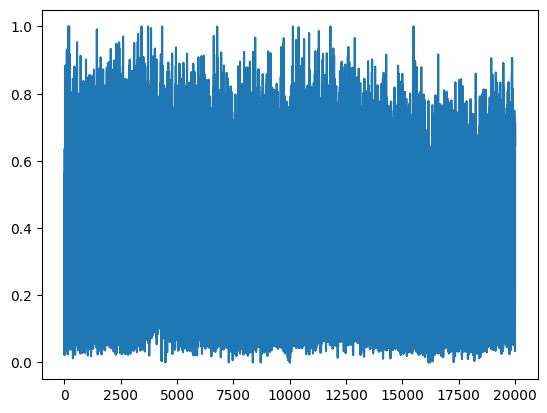

In [36]:
data = pd.read_csv('ar_df.csv')
data.dtypes
# convert VentasN to float
data['VentasN'] = data['VentasN'].str.replace(',', '.').astype(float)
y = data.iloc[:,1].head(20000)
y.plot()
plt.show()

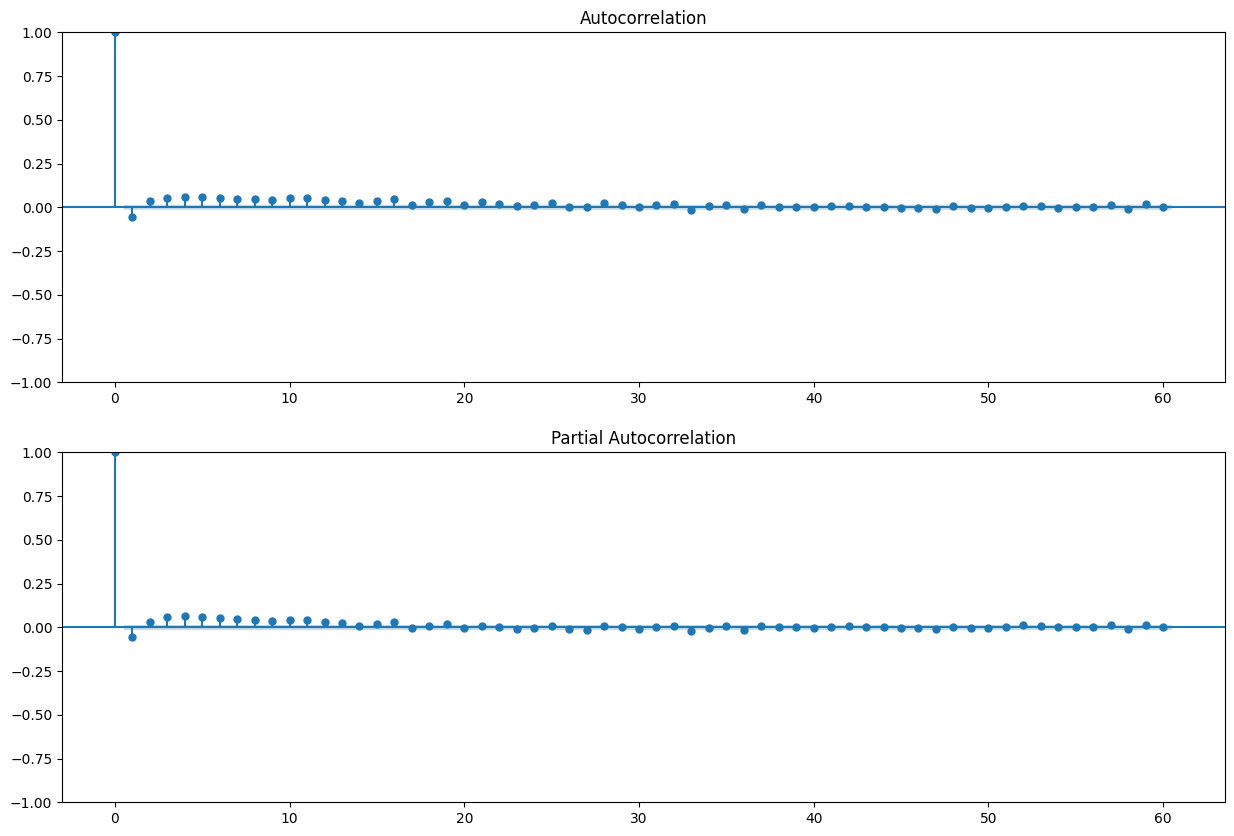

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 60 # play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(y, lags = nlags,  ax=ax[0])
plot_pacf(y, lags = nlags, method="ols",ax=ax[1])
plt.show()

In [38]:
s = 5 #seasonal parameter
import statsmodels.api as sm
from pmdarima.arima import ndiffs, nsdiffs

# Coincide con lo de R
print('Regular difference:', ndiffs(y, alpha = 0.05, test = 'adf'))
print('Seasonal difference:', nsdiffs(y, m = s, test = 'ocsb'))

Regular difference: 0
Seasonal difference: 0
